In [1]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

In [2]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [3]:

def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

Concatenating 68 csv files...
Loading done.


In [4]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate() # data may contain NAs, therefore inteprolate
    ret_data = ret_data.resample("1h").mean().interpolate() # not all hours may be  complete 
                                                            # (i.e. some last 15 minutes are lacking, therefore another inpolation here)

    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2016-01-01":"2019-12-31"]

In [5]:
def get_Y(data):
    Y = np.array(data["TotalLoadValue"]).reshape(-1, 1)
    
    return Y

Y = get_Y(power_demand_at_hourly)

In [6]:
def get_X(data, has_trend = False):

    monthly_dummies = np.array(pd.get_dummies(
        data.index.month))
    #[:, :11]

    weekday = np.array(pd.get_dummies(
        data.index.weekday))
    #[:, :6]

    hour = np.array(pd.get_dummies(
        data.index.hour))
    #[:, :23]

    trend = np.arange(0, len(hour)).reshape(-1, 1)
    
    X_out = np.append(monthly_dummies, weekday, axis=1)
    X_out = np.append(X_out, hour, axis=1)
    
    if(has_trend):
        X_out = np.append(X_out, trend, axis=1)
        
    return X_out
        
X = get_X(power_demand_at_hourly)


0.8354423954826933

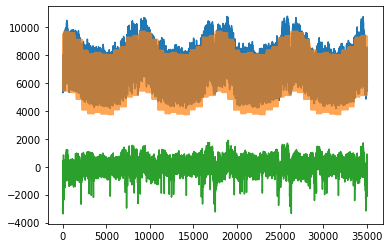

In [7]:
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X, Y)

pred = regr.predict(X)

r2_score(Y, pred)

plt.plot(Y)
plt.plot(pred, alpha=0.7)

residues = Y- pred
plt.plot(residues)
r2_score(Y,pred)

In [8]:
import xarray as xr
data = xr.load_dataset("G:/Meine Ablage/LVA/scientific computing/lecture-scientific-computing/data/temperatures_era5.nc")
temp_data = data.t2m.sel(longitude=16.5, latitude=48)
temp_data_year = temp_data.sel(time=slice('2016-01-01', '2019-12-31'))



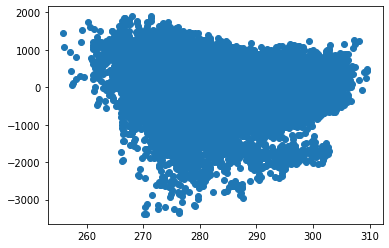

In [9]:
plt.scatter(temp_data_year.values, residues)

In [15]:
np.corrcoef(temp_data_year.values, residues.reshape(-1,))

array([[ 1.       , -0.1355615],
       [-0.1355615,  1.       ]])

In [16]:
def get_X(data, temp_data, has_trend = False):

    monthly_dummies = np.array(pd.get_dummies(
        data.index.month))
    #[:, :11]

    weekday = np.array(pd.get_dummies(
        data.index.weekday))
    #[:, :6]

    hour = np.array(pd.get_dummies(
        data.index.hour))
    #[:, :23]

    trend = np.arange(0, len(hour)).reshape(-1, 1)
    
    temp_data = temp_data.reshape(-1, 1)
    
    X_out = np.append(monthly_dummies, weekday, axis=1)
    X_out = np.append(X_out, hour, axis=1)
    X_out = np.append(X_out, temp_data, axis=1)
    
    
    
    if(has_trend):
        X_out = np.append(X_out, trend, axis=1)
        
    return X_out
        
X = get_X(power_demand_at_hourly, temp_data_year.values)

0.8524348483773861

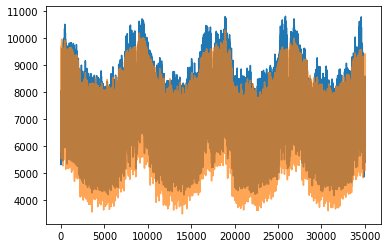

In [17]:
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(X, Y)

pred = regr.predict(X)

plt.plot(Y)
plt.plot(pred, alpha=0.7)

r2_score(Y, pred)